# 패키지 불러오기

In [1]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
from tqdm import tqdm

# 1. 데이터 준비하기
## 1.1. 도로 네트워크 정보 Preprocessing

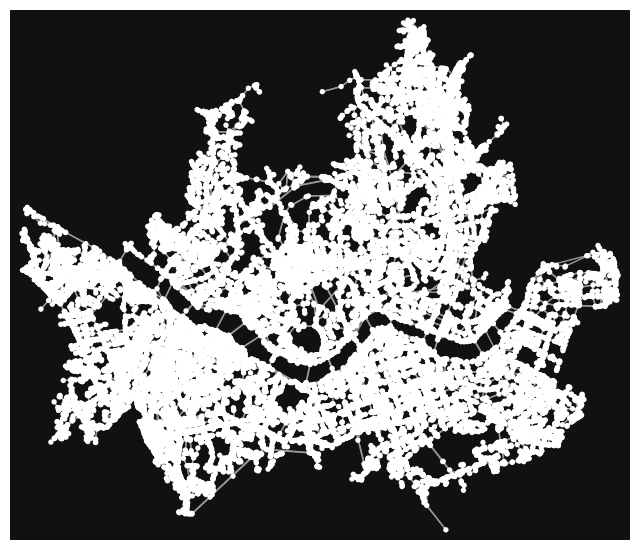

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
# 서울 도로네트워크 데이터 불러오기
G = ox.load_graphml(filepath='./data/road_network_5179.graphml', # 파일 경로
                    edge_dtypes={'length_meter': float, 
                                 'max_speed': int,
                                 'road_rank': str
                                 } # 불러올 속성의 데이터 타입을 지정
                    )
ox.plot_graph(G) # 도로네트워크 시각화

100%|██████████| 64129/64129 [00:54<00:00, 1185.43it/s]


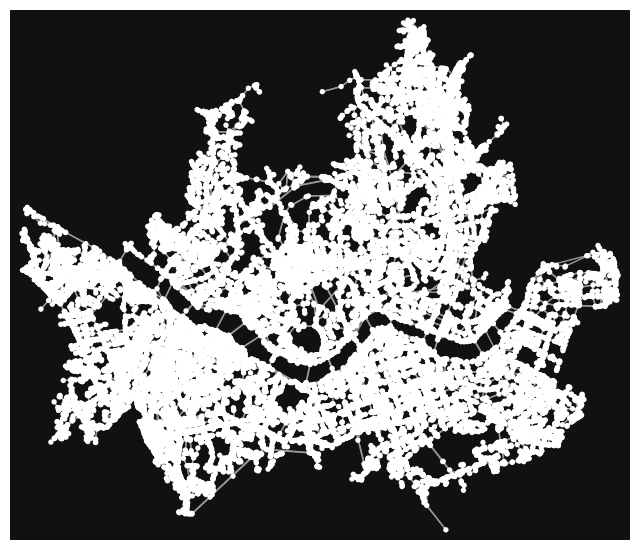

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
# 통행 속도 데이터 불러오기
speed_df = pd.read_csv('./data/traffic_speed.csv')

# Column 명에 공백 또는 특수문자가 포함되어 있어, 분석의 용의성을 위하여 Column 명을 변경
speed_df = speed_df.rename(columns={'﻿level6 LINK ID': 'link_id', '50% 주행속도 (km/h)': 'speed_kmh'})
speed_df.head(3)


# 네트워크 데이터에 통행 속도 정보를 할당하는 함수 정의

def assign_traffic_speed_data_to_network(_network, _speed_hour_df):

    _network_with_travel_time = _network.copy()

    for u, v, k, data in tqdm(_network_with_travel_time.edges(data=True, keys=True)):
        # Get speed from the hourly traffic speed data
        if data['osmid'] in _speed_hour_df['link_id'].unique():
            data['speed_kmh'] = _speed_hour_df.loc[_speed_hour_df['link_id'] == data['osmid'], 
                                                   'speed_kmh'].values[0]

        else: # If there is no speed data, use the max speed data
            data['speed_kmh'] = data['max_speed']

        # Manually set speed if there is no speed data
        if int(data['speed_kmh']) == 0:
            if data['road_rank'] == '101': # 고속도로
                data['speed_kmh'] = 100 # km/h
            elif data['road_rank'] == '102': # 도시고속도로
                data['speed_kmh'] = 80 
            # 일반국도, 특별/광역시도, 국가지원지방도, 일반지방도, 시군도
            elif data['road_rank'] in ['103', '104', '105', '106', '107']: 
                data['speed_kmh'] = 60
            elif data['road_rank'] == '108': # 고속도로 연결램프
                data['speed_kmh'] = 40
            else:
                raise ValueError('Unexpected Road Rank')
            
        # Calculate Travel Time per edge in seconds
        data['traffic_time_sec'] = data['length_meter'] / (data['speed_kmh'] * 1000 / 3600) # meter/sec

    return _network_with_travel_time

# 정의된 함수를 활용하여, 통행 속도 데이터를 네트워크 데이터에 할당
H = assign_traffic_speed_data_to_network(G, speed_df)

# 네터워크 모양은 동일함. 단, 각 엣지에 통행 속도 및 통행 시간이 할당되어 있음.
ox.plot_graph(H)

## 1.2. 읍면동 Geometry 불러오기

In [4]:
emd = gpd.read_file('./data/emd_5179.geojson')

nearest_osm = ox.nearest_nodes(H, emd['geometry'].centroid.x, emd['geometry'].centroid.y)

emd['osmid'] = nearest_osm
# emd['osmid'] = emd['osmid'].astype(str)
emd

BASE_DATE       ADM_NM    ADM_CD  \
0    20230701          사직동  11010530   
1    20230701          삼청동  11010540   
2    20230701          부암동  11010550   
3    20230701          평창동  11010560   
4    20230701          한남동  11030740   
..        ...          ...       ...   
421  20230701          가회동  11010600   
422  20230701  종로1·2·3·4가동  11010610   
423  20230701         방배2동  11220630   
424  20230701          미아동  11090700   
425  20230701          인수동  11090750   

                                              geometry   osmid  
0    POLYGON ((953553.932 1953335.741, 953555.211 1...  225886  
1    POLYGON ((954025.242 1953916.389, 954026.972 1...  227637  
2    POLYGON ((952490.380 1956548.821, 952497.594 1...  227760  
3    POLYGON ((953683.828 1959209.871, 953665.283 1...  228168  
4    POLYGON ((956238.296 1950166.610, 956237.942 1...  613893  
..                                                 ...     ...  
421  POLYGON ((954894.795 1954614.580, 954888.290 1...  223625  
422  POLYGON ((954918.389 1954371.538, 954926.411 1...  223949  
423  POLYGON ((954967.724 1942969.970, 954985.115 1...  813497  
424  POLYGON ((958301.054 1959603.612, 958292.609 1...  346425  
425  POLYGON ((956852.042 1960721.560, 956857.769 1...  346075  

[426 rows x 5 columns]

## 1.3. OD Matrix 계산하기 
OD Matrix: 출발지와 목적지 사이의 이동 비용 (거리, 시간 등)을 계산한 표

In [5]:
emd.loc[emd['ADM_NM'] == '회기동']

BASE_DATE ADM_NM    ADM_CD  \
186  20230701    회기동  11060710   

                                              geometry   osmid  
186  POLYGON ((960540.208 1955635.067, 960542.330 1...  347649

In [6]:
# 각 출발지점에서 모든 위치까지의 최단 이동 시간 계산

# Syntax: 
# {osmid: travel_time, 
#  osmid: travel_time, ...
# }, 

temp_dic = nx.single_source_dijkstra_path_length(H, # 네트워크 데이터 (통행 시간이 할당된)
                                                347649, # 출발 OSM 노드
                                                weight='traffic_time_sec' # 통행 시간을 weight로 활용
                                                )
temp_dic

{347649: 0,
 347650: 5.510645079337966,
 345501: np.float64(5.740798424427428),
 347648: 10.380115304428458,
 347647: 11.469013249365869,
 347652: 13.474762676627616,
 563330: np.float64(31.842911065705845),
 345500: np.float64(81.96243364467195),
 347057: np.float64(113.96262083004268),
 346289: np.float64(115.15582101229074),
 346288: np.float64(117.88689618711167),
 348387: np.float64(121.09344765511871),
 647525: np.float64(125.8986716768789),
 348448: np.float64(136.24826460005758),
 346866: np.float64(136.77131337531858),
 347056: np.float64(137.80562086467515),
 346867: np.float64(142.80814643261715),
 345558: np.float64(143.87577169233145),
 346360: np.float64(152.15894641802825),
 346346: np.float64(163.23116192898155),
 345555: np.float64(164.14784841921326),
 346347: np.float64(164.71425958556972),
 647888: np.float64(169.50195319376144),
 345493: np.float64(172.53232498331312),
 647889: np.float64(173.07954419840092),
 345492: np.float64(175.2725513440736),
 647887: np.floa

각 읍면동의 OSMID와 관련이 된 최단 이동 시간만을 추출

In [7]:
# List Comprehension
[(_key, _val) for _key, _val in temp_dic.items()] # 회기동에서 접근가능한 모든 노드에 대한 최단 이동 시간
# len([(_key, _val) for _key, _val in temp_dic.items()]) # 회기동에서 접근가능한 모든 노드에 대한 최단 이동 시간 개수

[(347649, 0),
 (347650, 5.510645079337966),
 (345501, np.float64(5.740798424427428)),
 (347648, 10.380115304428458),
 (347647, 11.469013249365869),
 (347652, 13.474762676627616),
 (563330, np.float64(31.842911065705845)),
 (345500, np.float64(81.96243364467195)),
 (347057, np.float64(113.96262083004268)),
 (346289, np.float64(115.15582101229074)),
 (346288, np.float64(117.88689618711167)),
 (348387, np.float64(121.09344765511871)),
 (647525, np.float64(125.8986716768789)),
 (348448, np.float64(136.24826460005758)),
 (346866, np.float64(136.77131337531858)),
 (347056, np.float64(137.80562086467515)),
 (346867, np.float64(142.80814643261715)),
 (345558, np.float64(143.87577169233145)),
 (346360, np.float64(152.15894641802825)),
 (346346, np.float64(163.23116192898155)),
 (345555, np.float64(164.14784841921326)),
 (346347, np.float64(164.71425958556972)),
 (647888, np.float64(169.50195319376144)),
 (345493, np.float64(172.53232498331312)),
 (647889, np.float64(173.07954419840092)),
 (3454

In [8]:
[(_key, _val) for _key, _val in temp_dic.items() if _key in emd['osmid'].values] # 회기동에서 접근가능한 읍면동과 관련된 노드에 대한 최단 이동 시간
# len([(_key, _val) for _key, _val in temp_dic.items() if _key in emd['osmid'].values]) # 회기동에서 접근가능한 읍면동과 관련된 노드에 대한 최단 이동 시간 개수

[(347649, 0),
 (346257, np.float64(269.3072342880024)),
 (347769, np.float64(290.28901255816635)),
 (345954, np.float64(305.83023881308316)),
 (345478, np.float64(341.7199836134694)),
 (340837, np.float64(425.21765723306964)),
 (588168, np.float64(434.62674794387226)),
 (340596, np.float64(440.26913330271174)),
 (345443, np.float64(441.6656071448323)),
 (346154, np.float64(452.9867961195692)),
 (346641, np.float64(463.20024090167436)),
 (348418, np.float64(480.99098610065977)),
 (347742, np.float64(500.1143651637357)),
 (344550, np.float64(521.3745282104233)),
 (342282, np.float64(559.568805339639)),
 (613834, np.float64(574.742958445596)),
 (343569, np.float64(577.7690095568769)),
 (647486, np.float64(595.9350085999553)),
 (348599, np.float64(608.6434569791057)),
 (563239, np.float64(609.2408841991754)),
 (647437, np.float64(610.3818372247966)),
 (346277, np.float64(612.8528072956867)),
 (346270, np.float64(617.837721698386)),
 (341870, np.float64(626.5068629574436)),
 (344951, np.flo

In [9]:
{_key: _val for _key, _val in temp_dic.items() if _key in emd['osmid'].values} # List Comprehension을 Dictionary Comprehension으로 변경
# len({_key: _val for _key, _val in temp_dic.items() if _key in emd['osmid'].values}) # 개수는 동일

{347649: 0,
 346257: np.float64(269.3072342880024),
 347769: np.float64(290.28901255816635),
 345954: np.float64(305.83023881308316),
 345478: np.float64(341.7199836134694),
 340837: np.float64(425.21765723306964),
 588168: np.float64(434.62674794387226),
 340596: np.float64(440.26913330271174),
 345443: np.float64(441.6656071448323),
 346154: np.float64(452.9867961195692),
 346641: np.float64(463.20024090167436),
 348418: np.float64(480.99098610065977),
 347742: np.float64(500.1143651637357),
 344550: np.float64(521.3745282104233),
 342282: np.float64(559.568805339639),
 613834: np.float64(574.742958445596),
 343569: np.float64(577.7690095568769),
 647486: np.float64(595.9350085999553),
 348599: np.float64(608.6434569791057),
 563239: np.float64(609.2408841991754),
 647437: np.float64(610.3818372247966),
 346277: np.float64(612.8528072956867),
 346270: np.float64(617.837721698386),
 341870: np.float64(626.5068629574436),
 344951: np.float64(661.0161923681745),
 647677: np.float64(671.

In [10]:
# 위의 Dictionary Comprehension을 읍면동의 순서를 기준으로 변경
origin_time_dic_slice = {osmid: temp_dic[osmid] for osmid in emd['osmid'].values if osmid in temp_dic.keys()}
origin_time_dic_slice

{np.int64(225886): np.float64(1544.7891391640826),
 np.int64(227637): np.float64(1449.9002539627356),
 np.int64(227760): np.float64(1497.3639590092184),
 np.int64(228168): np.float64(1410.5672920937445),
 np.int64(613893): np.float64(1423.9724012566871),
 np.int64(344469): np.float64(916.1048477341058),
 np.int64(342921): np.float64(772.7632188847297),
 np.int64(223619): np.float64(1704.5391807952906),
 np.int64(343183): np.float64(1276.9378689144942),
 np.int64(340600): np.float64(1201.3609192807376),
 np.int64(340787): np.float64(998.614122255102),
 np.int64(342951): np.float64(907.4365999482692),
 np.int64(226533): np.float64(1784.7145325878528),
 np.int64(224585): np.float64(1539.4238262471906),
 np.int64(223266): np.float64(1746.8292895459954),
 np.int64(225090): np.float64(2120.7576169640315),
 np.int64(223267): np.float64(2065.184826682042),
 np.int64(225668): np.float64(2111.7473719021277),
 np.int64(636687): np.float64(1762.4256343479408),
 np.int64(344244): np.float64(1001.90

In [11]:
# 위의 사항을 함수로 정의

def calculate_OD_matrix(_network, _pnt_gdf, _weight):

    # Caclulate Travel Time between every pair of nodes
    od_matrix_dic = {}
    # Syntax: 
    #  {osmid: 
    #      {osmid: travel_time, 
    #       osmid: travel_time, ...
    #      }, 
    #  osmid:
    #      {osmid: travel_time, 
    #       osmid: travel_time, ...
    #      }, ...
    #  }, ...

    for idx, row in tqdm(_pnt_gdf.iterrows(), total=_pnt_gdf.shape[0]):
        # Calculate Travel Time from the origin node to all other nodes
        origin_time_dic = nx.single_source_dijkstra_path_length(_network, row['osmid'], weight=_weight)

        # Select keys that are in the zone_pnt_gdf (집계구와 연결된 osmid node만 선택)
        origin_time_dic_slice = {osmid: origin_time_dic[osmid] for osmid in _pnt_gdf['osmid'].values if osmid in origin_time_dic.keys()}
        od_matrix_dic[row['osmid']] = origin_time_dic_slice

    # Change dictionary to DataFrame
    # Rows: Origin Nodes
    # Columns: Destination Nodes
    # if odmatrix.loc[i, j] = x, it means that it takes x seconds to travel from node i to node j
    od_matrix_df = pd.DataFrame(od_matrix_dic)
    od_matrix_df = od_matrix_df.T
    od_matrix_df.index.name = 'origin'

    # Convert Datatype from Float to Int
    for col in od_matrix_df.columns:
        od_matrix_df[col] = od_matrix_df[col].astype(int)

    # Rows: Origin Nodes
    # Columns: Destination Nodes
    # if odmatrix.loc[i, j] = x, it means that it takes x seconds to travel from node i to node j
    return od_matrix_df

od_matrix = calculate_OD_matrix(H, emd, 'traffic_time_sec')
od_matrix

100%|██████████| 426/426 [00:31<00:00, 13.43it/s]


225886  227637  227760  228168  613893  344469  342921  223619  \
origin                                                                   
225886       0     443     456     882     806    1078    1179     408   
227637     470       0     556     982     997    1229    1331     794   
227760     400     596       0     425    1066    1337    1261     708   
228168     851    1046     450       0    1516    1317    1187    1158   
613893     680     788    1002    1427       0     758     855     688   
...        ...     ...     ...     ...     ...     ...     ...     ...   
223625     511     142     629    1054     939    1104    1206     835   
223949     625     421     743    1168     811     865     967     806   
813497    1591    1751    1953    2379    1091    1505    1598    1417   
346425    1804    1458    1404    1317    1768    1203    1072    1989   
346075    1895    1593    1494    1407    2236    1727    1597    2202   

        343183  340600  ...  356094  357546  356202  356688  637014  223625  \
origin                  ...                                                   
225886    1174     821  ...    2564    2763    2797    2751     168     470   
227637    1365    1012  ...    2712    2911    2945    2899     573     124   
227760    1434    1081  ...    2527    2726    2761    2715     468     654   
228168    1574    1531  ...    2453    2652    2686    2640     918    1104   
613893     368     261  ...    1757    1956    1990    1945     734     816   
...        ...     ...  ...     ...     ...     ...     ...     ...     ...   
223625    1307     897  ...    2587    2786    2820    2774     614       0   
223949    1074     643  ...    2348    2547    2581    2535     700     305   
813497    1074    1253  ...    2219    2346    2446    2335    1645    1778   
346425    1460    1546  ...    2338    2537    2572    2526    1872    1456   
346075    1985    2014  ...    2863    3062    3096    3050    1962    1663   

        223949  813497  346425  346075  
origin                                  
225886     490    1861    1677    1953  
227637     428    2104    1377    1551  
227760     702    2121    1221    1496  
228168    1153    2571    1146    1421  
613893     736    1304    1793    2301  
...        ...     ...     ...     ...  
223625     303    2109    1479    1653  
223949       0    1981    1320    1770  
813497    1777       0    2459    3006  
346425    1261    2984       0     560  
346075    1603    3451     609       0  

[426 rows x 426 columns]

In [12]:
# Columm과 Index의 데이터 타입을 String으로 변경

od_matrix.columns = od_matrix.columns.astype(str)
od_matrix.index = od_matrix.index.astype(str)

In [13]:
# OD Matrix 저장
# od_matrix.to_csv('./data/od_matrix_202208_H17.csv')

## 1.4. OD Matrix 값 점검

In [14]:
emd.loc[emd['ADM_NM'] == '아현동']

BASE_DATE ADM_NM    ADM_CD  \
284  20230701    아현동  11140780   

                                              geometry   osmid  
284  POLYGON ((952277.530 1951063.886, 952281.042 1...  226773

In [15]:
emd.loc[emd['ADM_NM'] == '회기동']

BASE_DATE ADM_NM    ADM_CD  \
186  20230701    회기동  11060710   

                                              geometry   osmid  
186  POLYGON ((960540.208 1955635.067, 960542.330 1...  347649

In [16]:
# 아현동에서 회기동까지의 이동시간 (분)
nx.dijkstra_path_length(H, 226773, 347649, weight='traffic_time_sec') 

np.float64(1995.1578750951219)

In [17]:
od_matrix.loc['226773', '347649'] 

np.int64(1995)

# 2. People-based Accessibilty 계산

![](./data/space_time_prism.jpg)

Source: https://doi.org/10.1111/j.1538-4632.2005.00575.x

## 2.1. Space-Time Prism: 각 출발 지점과 도착 지점에서 각 지역까지 이동 시간 계산

In [18]:
# 모든 읍면동을 대상으로 출발읍면동과 도착읍면동까지 이동시간을 계산할 것임.
_stp_df = emd[['ADM_CD', 'ADM_NM', 'osmid']].copy()
_stp_df['osmid'] = _stp_df['osmid'].astype(str) # 각 읍면동의 Osmid를 문자열로 사용하고 있기 때문에, 문자열로 데이터타입을 변경
_stp_df

ADM_CD       ADM_NM   osmid
0    11010530          사직동  225886
1    11010540          삼청동  227637
2    11010550          부암동  227760
3    11010560          평창동  228168
4    11030740          한남동  613893
..        ...          ...     ...
421  11010600          가회동  223625
422  11010610  종로1·2·3·4가동  223949
423  11220630         방배2동  813497
424  11090700          미아동  346425
425  11090750          인수동  346075

[426 rows x 3 columns]

In [19]:
# 필요한 변수들
_od_matrix = od_matrix.copy()
_origin_osmid = '347649'
_dest_osmid = '226773'
_max_trvl_time = 45 # minutes # 기존 이동시간 + 추가 이동시간

In [20]:
# apply와 lambda를 사용하면 for-loop를 빠르게 계산할 수 있음. 
_stp_df.apply(lambda x: x['osmid'], axis=1)

0      225886
1      227637
2      227760
3      228168
4      613893
        ...  
421    223625
422    223949
423    813497
424    346425
425    346075
Length: 426, dtype: object

In [21]:
_od_matrix.loc[_origin_osmid, _dest_osmid]

np.int64(1905)

In [22]:
# Retrieve the travel time (in seconds) from the origin zone to each zone of interest
_stp_df['travel_time_from_origin'] = _stp_df.apply(lambda x: (_od_matrix.loc[_origin_osmid, x['osmid']]) / 60, axis=1) # Minutes
_stp_df

ADM_CD       ADM_NM   osmid  travel_time_from_origin
0    11010530          사직동  225886                25.733333
1    11010540          삼청동  227637                24.150000
2    11010550          부암동  227760                24.950000
3    11010560          평창동  228168                23.500000
4    11030740          한남동  613893                23.716667
..        ...          ...     ...                      ...
421  11010600          가회동  223625                23.900000
422  11010610  종로1·2·3·4가동  223949                20.650000
423  11220630         방배2동  813497                43.983333
424  11090700          미아동  346425                15.800000
425  11090750          인수동  346075                24.916667

[426 rows x 4 columns]

In [23]:
# Retrieve the travel time (in seconds) from each zone of interest to the destination zone
_stp_df['travel_time_to_dest'] = _stp_df.apply(lambda x: (_od_matrix.loc[x['osmid'], _dest_osmid]) / 60, axis=1) # Minutes
_stp_df

ADM_CD       ADM_NM   osmid  travel_time_from_origin  \
0    11010530          사직동  225886                25.733333   
1    11010540          삼청동  227637                24.150000   
2    11010550          부암동  227760                24.950000   
3    11010560          평창동  228168                23.500000   
4    11030740          한남동  613893                23.716667   
..        ...          ...     ...                      ...   
421  11010600          가회동  223625                23.900000   
422  11010610  종로1·2·3·4가동  223949                20.650000   
423  11220630         방배2동  813497                43.983333   
424  11090700          미아동  346425                15.800000   
425  11090750          인수동  346075                24.916667   

     travel_time_to_dest  
0               9.433333  
1              15.866667  
2              14.433333  
3              21.933333  
4              15.250000  
..                   ...  
421            16.550000  
422            16.783333  
423            26.483333  
424            36.516667  
425            39.333333  

[426 rows x 5 columns]

In [24]:
# Calculate the total travel time
_stp_df['travel_time_total'] = _stp_df['travel_time_from_origin'] + _stp_df['travel_time_to_dest']
_stp_df

ADM_CD       ADM_NM   osmid  travel_time_from_origin  \
0    11010530          사직동  225886                25.733333   
1    11010540          삼청동  227637                24.150000   
2    11010550          부암동  227760                24.950000   
3    11010560          평창동  228168                23.500000   
4    11030740          한남동  613893                23.716667   
..        ...          ...     ...                      ...   
421  11010600          가회동  223625                23.900000   
422  11010610  종로1·2·3·4가동  223949                20.650000   
423  11220630         방배2동  813497                43.983333   
424  11090700          미아동  346425                15.800000   
425  11090750          인수동  346075                24.916667   

     travel_time_to_dest  travel_time_total  
0               9.433333          35.166667  
1              15.866667          40.016667  
2              14.433333          39.383333  
3              21.933333          45.433333  
4              15.250000          38.966667  
..                   ...                ...  
421            16.550000          40.450000  
422            16.783333          37.433333  
423            26.483333          70.466667  
424            36.516667          52.316667  
425            39.333333          64.250000  

[426 rows x 6 columns]

In [25]:
# Filter out the zones that exceed the maximum travel time
_stp_df = _stp_df.loc[_stp_df['travel_time_total'] <= _max_trvl_time].reset_index(drop=True)
_stp_df

ADM_CD       ADM_NM   osmid  travel_time_from_origin  \
0   11010530          사직동  225886                25.733333   
1   11010540          삼청동  227637                24.150000   
2   11010550          부암동  227760                24.950000   
3   11030740          한남동  613893                23.716667   
4   11040520        왕십리2동  344469                15.266667   
..       ...          ...     ...                      ...   
94  11140780          아현동  226773                31.750000   
95  11190540          여의동  224341                37.133333   
96  11010580          교남동  637014                26.633333   
97  11010600          가회동  223625                23.900000   
98  11010610  종로1·2·3·4가동  223949                20.650000   

    travel_time_to_dest  travel_time_total  
0              9.433333          35.166667  
1             15.866667          40.016667  
2             14.433333          39.383333  
3             15.250000          38.966667  
4             24.266667          39.533333  
..                  ...                ...  
94             0.000000          31.750000  
95             7.050000          44.183333  
96             8.350000          34.983333  
97            16.550000          40.450000  
98            16.783333          37.433333  

[99 rows x 6 columns]

In [26]:
# 위의 내용을 함수로 정리하면 아래와 같음. 
def calculate_stp(_gdf, _od_matrix, _origin_osmid, _dest_osmid, _max_trvl_time):
    # _gdf : geopandas.GeoDataFrame (Point); has 'ADM_CD', 'ADM_NM', 'osmid'
    # _od_matrix : pandas.DataFrame; has 'origin' (OSMID of Origin Zone) as rows and 'destination' (OSMID of Destination Zone) as columns
    # _origin_osmid : str # Origin 지역의 OSMID
    # _dest_osmid : str # Destination 지역의 OSMID
    # _max_trvl_time_ : int

    # Get the origin and destination zone ID & their OSMID
    _stp_df = _gdf[['ADM_CD', 'ADM_NM', 'osmid']].copy()
    _stp_df['osmid'] = _stp_df['osmid'].astype(str) # 각 읍면동의 Osmid를 문자열로 사용하고 있기 때문에, 문자열로 데이터타입을 변경

    # Retrieve the travel time (in seconds) from the origin zone to each zone of interest
    _stp_df['travel_time_from_origin'] = _stp_df.apply(lambda x: (_od_matrix.loc[_origin_osmid, x['osmid']]) / 60, axis=1) # Minutes

    # Retrieve the travel time (in seconds) from each zone of interest to the destination zone
    _stp_df['travel_time_to_dest'] = _stp_df.apply(lambda x: (_od_matrix.loc[x['osmid'], _dest_osmid]) / 60, axis=1) # Minutes

    # Calculate the total travel time
    _stp_df['travel_time_total'] = _stp_df['travel_time_from_origin'] + _stp_df['travel_time_to_dest']

    # Filter out the zones that exceed the maximum travel time
    _stp_df = _stp_df.loc[_stp_df['travel_time_total'] <= _max_trvl_time].reset_index(drop=True)

    # _stp_df has following columns
    # # ADM_CD: 행정동 코드
    # # ADM_NM: 행정동 이름
    # # osmid: 행정동의 중심점과 가장 가까운 OSMID
    # # travel_time_from_origin: Origin에서 해당 지역까지의 이동시간
    # # travel_time_to_dest: 해당 지역에서 Destination까지의 이동시간
    # # travel_time_total: Space-Time Prism (Origin Zone에서 해당 집계구까지 이동하고, 해당 집계구에서 Destination Zone까지 이동하는데 걸리는 총 이동시간)

    return _stp_df


stp_df = calculate_stp(emd, # 읍면동 데이터
              od_matrix, # OD Matrix Data Frame
              '347649', # 출발지 OSMID (회기동)
              '226773', # 목적지 OSMID (아현동)
              42 # 최대 이동 시간
              )
stp_df

ADM_CD       ADM_NM   osmid  travel_time_from_origin  \
0   11010530          사직동  225886                25.733333   
1   11010540          삼청동  227637                24.150000   
2   11010550          부암동  227760                24.950000   
3   11030740          한남동  613893                23.716667   
4   11040520        왕십리2동  344469                15.266667   
..       ...          ...     ...                      ...   
73  11140750          도화동  225092                34.550000   
74  11140780          아현동  226773                31.750000   
75  11010580          교남동  637014                26.633333   
76  11010600          가회동  223625                23.900000   
77  11010610  종로1·2·3·4가동  223949                20.650000   

    travel_time_to_dest  travel_time_total  
0              9.433333          35.166667  
1             15.866667          40.016667  
2             14.433333          39.383333  
3             15.250000          38.966667  
4             24.266667          39.533333  
..                  ...                ...  
73             6.183333          40.733333  
74             0.000000          31.750000  
75             8.350000          34.983333  
76            16.550000          40.450000  
77            16.783333          37.433333  

[78 rows x 6 columns]

In [27]:
emd.merge(stp_df[['ADM_CD', 'travel_time_from_origin', 'travel_time_to_dest', 'travel_time_total']], on='ADM_CD').explore('travel_time_total')

## 2.2. Space-Time Prism의 일정 시간당 이동 가능한 지역 계산
![](./data/space_time_prism_slice.jpg)

In [28]:
_max_trvl_time = 45 # minutes # 기존 이동시간 + 추가 이동시간
_time_interval = 5 # minutes

# Define the gap of the time zones
_stp_df = pd.concat([_stp_df, pd.DataFrame(columns=[f'zone_{str(t).zfill(3)}' for t in range(0, int(_max_trvl_time)+1, _time_interval)][1:])]) # Adding columns for each 5 minutes zone
_stp_total_time = [trvl_time for trvl_time in range(0, int(_max_trvl_time)+1, _time_interval)] # 0, 5, 10, 15, ..., max travel time + 60 minutes of shopping time


In [29]:
_stp_df

ADM_CD       ADM_NM   osmid  travel_time_from_origin  \
0   11010530          사직동  225886                25.733333   
1   11010540          삼청동  227637                24.150000   
2   11010550          부암동  227760                24.950000   
3   11030740          한남동  613893                23.716667   
4   11040520        왕십리2동  344469                15.266667   
..       ...          ...     ...                      ...   
94  11140780          아현동  226773                31.750000   
95  11190540          여의동  224341                37.133333   
96  11010580          교남동  637014                26.633333   
97  11010600          가회동  223625                23.900000   
98  11010610  종로1·2·3·4가동  223949                20.650000   

    travel_time_to_dest  travel_time_total zone_005 zone_010 zone_015  \
0              9.433333          35.166667      NaN      NaN      NaN   
1             15.866667          40.016667      NaN      NaN      NaN   
2             14.433333          39.383333      NaN      NaN      NaN   
3             15.250000          38.966667      NaN      NaN      NaN   
4             24.266667          39.533333      NaN      NaN      NaN   
..                  ...                ...      ...      ...      ...   
94             0.000000          31.750000      NaN      NaN      NaN   
95             7.050000          44.183333      NaN      NaN      NaN   
96             8.350000          34.983333      NaN      NaN      NaN   
97            16.550000          40.450000      NaN      NaN      NaN   
98            16.783333          37.433333      NaN      NaN      NaN   

   zone_020 zone_025 zone_030 zone_035 zone_040 zone_045  
0       NaN      NaN      NaN      NaN      NaN      NaN  
1       NaN      NaN      NaN      NaN      NaN      NaN  
2       NaN      NaN      NaN      NaN      NaN      NaN  
3       NaN      NaN      NaN      NaN      NaN      NaN  
4       NaN      NaN      NaN      NaN      NaN      NaN  
..      ...      ...      ...      ...      ...      ...  
94      NaN      NaN      NaN      NaN      NaN      NaN  
95      NaN      NaN      NaN      NaN      NaN      NaN  
96      NaN      NaN      NaN      NaN      NaN      NaN  
97      NaN      NaN      NaN      NaN      NaN      NaN  
98      NaN      NaN      NaN      NaN      NaN      NaN  

[99 rows x 15 columns]

In [30]:
_stp_total_time

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

In [31]:
# Iterate through each time interval
for idx, trvl_time in enumerate(_stp_total_time):
    if idx == 0:
        continue

    # Calculate travel time from the origin to each of the zone and get zone ID (i.e., how long would it take to get to the zone from the origin) 
    loc_closed_to_start_id = _stp_df.loc[(_stp_df['travel_time_from_origin'] >= _stp_total_time[idx-1]) & 
                                            (_stp_df['travel_time_from_origin'] <= _stp_total_time[idx]), 
                                            'ADM_CD'].values

    # Calculate travel time from each of the zone to the destination and get zone ID 
    # (i.e., how long would it take to get to the destination from the zone)
    loc_closed_to_end_id = _stp_df.loc[(_stp_df['travel_time_to_dest'] >= _stp_total_time[idx-1]) & 
                                        (_stp_df['travel_time_to_dest'] <= _stp_total_time[idx]), 
                                        'ADM_CD'].values

    # Assign 'Y' to the zone that is closed to the start and end / or that can be reached within the time interval
    _stp_df.loc[_stp_df['ADM_CD'].isin(loc_closed_to_start_id), f'zone_{str(trvl_time).zfill(3)}'] = 'Y'
    _stp_df.loc[_stp_df['ADM_CD'].isin(loc_closed_to_end_id), f'zone_{str(int(_max_trvl_time) - trvl_time).zfill(3)}'] = 'Y'
    
_stp_df = _stp_df.reset_index(drop=True)
_stp_df = _stp_df.reindex(sorted(_stp_df.columns), axis=1)
_stp_df


ADM_CD       ADM_NM   osmid  travel_time_from_origin  \
0   11010530          사직동  225886                25.733333   
1   11010540          삼청동  227637                24.150000   
2   11010550          부암동  227760                24.950000   
3   11030740          한남동  613893                23.716667   
4   11040520        왕십리2동  344469                15.266667   
..       ...          ...     ...                      ...   
94  11140780          아현동  226773                31.750000   
95  11190540          여의동  224341                37.133333   
96  11010580          교남동  637014                26.633333   
97  11010600          가회동  223625                23.900000   
98  11010610  종로1·2·3·4가동  223949                20.650000   

    travel_time_to_dest  travel_time_total zone_000 zone_005 zone_010  \
0              9.433333          35.166667      NaN      NaN      NaN   
1             15.866667          40.016667      NaN      NaN      NaN   
2             14.433333          39.383333      NaN      NaN      NaN   
3             15.250000          38.966667      NaN      NaN      NaN   
4             24.266667          39.533333      NaN      NaN      NaN   
..                  ...                ...      ...      ...      ...   
94             0.000000          31.750000      NaN      NaN      NaN   
95             7.050000          44.183333      NaN      NaN      NaN   
96             8.350000          34.983333      NaN      NaN      NaN   
97            16.550000          40.450000      NaN      NaN      NaN   
98            16.783333          37.433333      NaN      NaN      NaN   

   zone_015 zone_020 zone_025 zone_030 zone_035 zone_040 zone_045  
0       NaN      NaN      NaN        Y        Y      NaN      NaN  
1       NaN      NaN        Y      NaN      NaN      NaN      NaN  
2       NaN      NaN        Y        Y      NaN      NaN      NaN  
3       NaN      NaN        Y      NaN      NaN      NaN      NaN  
4       NaN        Y      NaN      NaN      NaN      NaN      NaN  
..      ...      ...      ...      ...      ...      ...      ...  
94      NaN      NaN      NaN      NaN        Y        Y      NaN  
95      NaN      NaN      NaN      NaN        Y        Y      NaN  
96      NaN      NaN      NaN        Y        Y      NaN      NaN  
97      NaN      NaN        Y      NaN      NaN      NaN      NaN  
98      NaN      NaN        Y      NaN      NaN      NaN      NaN  

[99 rows x 16 columns]

In [32]:
# 값을 엑셀에서 확인하기
# _stp_df.to_csv('./data/stp_slice_missing_value.csv', index=False)

위의 코드를 돌리면, 특정 지역이 출발지, 도착지에서 접근가능할 경우에 중간에 Y가 들어가지 않은 지역이 있음. 이를 아래의 코드를 활용하여 보충함. 

In [33]:
# Select the zone that can be reached within each time zone
for idx, row in _stp_df.iterrows():
    idx_ary = row.index.to_numpy()
    value_ary = row.values

    # Get columns that has True value (accessible zone from the origin zone & zone that can access to the destination zone)
    _access_time_zones = idx_ary[value_ary == 'Y'].tolist()  

    # Get just number of travel time zone
    _access_time_zones = [int(_zone.split('_')[1]) for _zone in _access_time_zones]

    # Fill the gap between the accessible zone 
    # For example, if the travel time from the origin is 10 minutes (zone_10 is True) and 
    # the travel time to the destination is 30 minutes (zone_30 is True),
    # the code fill in the columns between zone_10 and zone_30 with True value
    _zone_btwn = [_trvl_time for _trvl_time in _stp_total_time if _trvl_time < max(_access_time_zones) and _trvl_time > min(_access_time_zones)]

    for fill_time in _zone_btwn:
        _stp_df.loc[idx, f'zone_{str(fill_time).zfill(3)}'] = 'Y'

_stp_df

ADM_CD       ADM_NM   osmid  travel_time_from_origin  \
0   11010530          사직동  225886                25.733333   
1   11010540          삼청동  227637                24.150000   
2   11010550          부암동  227760                24.950000   
3   11030740          한남동  613893                23.716667   
4   11040520        왕십리2동  344469                15.266667   
..       ...          ...     ...                      ...   
94  11140780          아현동  226773                31.750000   
95  11190540          여의동  224341                37.133333   
96  11010580          교남동  637014                26.633333   
97  11010600          가회동  223625                23.900000   
98  11010610  종로1·2·3·4가동  223949                20.650000   

    travel_time_to_dest  travel_time_total zone_000 zone_005 zone_010  \
0              9.433333          35.166667      NaN      NaN      NaN   
1             15.866667          40.016667      NaN      NaN      NaN   
2             14.433333          39.383333      NaN      NaN      NaN   
3             15.250000          38.966667      NaN      NaN      NaN   
4             24.266667          39.533333      NaN      NaN      NaN   
..                  ...                ...      ...      ...      ...   
94             0.000000          31.750000      NaN      NaN      NaN   
95             7.050000          44.183333      NaN      NaN      NaN   
96             8.350000          34.983333      NaN      NaN      NaN   
97            16.550000          40.450000      NaN      NaN      NaN   
98            16.783333          37.433333      NaN      NaN      NaN   

   zone_015 zone_020 zone_025 zone_030 zone_035 zone_040 zone_045  
0       NaN      NaN      NaN        Y        Y      NaN      NaN  
1       NaN      NaN        Y      NaN      NaN      NaN      NaN  
2       NaN      NaN        Y        Y      NaN      NaN      NaN  
3       NaN      NaN        Y      NaN      NaN      NaN      NaN  
4       NaN        Y      NaN      NaN      NaN      NaN      NaN  
..      ...      ...      ...      ...      ...      ...      ...  
94      NaN      NaN      NaN      NaN        Y        Y      NaN  
95      NaN      NaN      NaN      NaN        Y        Y      NaN  
96      NaN      NaN      NaN        Y        Y      NaN      NaN  
97      NaN      NaN        Y      NaN      NaN      NaN      NaN  
98      NaN      NaN        Y      NaN      NaN      NaN      NaN  

[99 rows x 16 columns]

In [34]:
# 값을 엑셀에서 확인하기
# _stp_df.to_csv('./data/stp_slice_completed.csv', index=False)

In [35]:
# 위의 코드를 정리하면 아래와 같음. 

def retrieve_accessible_locations_per_time_zone(_stp_df, _max_trvl_time, _time_interval):
    # _stp_df : pd.DataFrame
    # _max_trvl_time : int
    # _time_interval : int (default: 5 minutes)

    # Define the gap of the time zones
    _stp_df = pd.concat([_stp_df, pd.DataFrame(columns=[f'zone_{str(t).zfill(3)}' for t in range(0, int(_max_trvl_time)+1, _time_interval)][1:])]) # Adding columns for each 5 minutes zone
    _stp_total_time = [trvl_time for trvl_time in range(0, int(_max_trvl_time)+1, _time_interval)] # 0, 5, 10, 15, ..., max travel time + 60 minutes of shopping time

    # Iterate through each time interval
    for idx, trvl_time in enumerate(_stp_total_time):
        if idx == 0:
            continue

        # Calculate travel time from the origin to each of the zone and get zone ID (i.e., how long would it take to get to the zone from the origin) 
        loc_closed_to_start_id = _stp_df.loc[(_stp_df['travel_time_from_origin'] >= _stp_total_time[idx-1]) & 
                                                (_stp_df['travel_time_from_origin'] <= _stp_total_time[idx]), 
                                                'ADM_CD'].values

        # Calculate travel time from each of the zone to the destination and get zone ID 
        # (i.e., how long would it take to get to the destination from the zone)
        loc_closed_to_end_id = _stp_df.loc[(_stp_df['travel_time_to_dest'] >= _stp_total_time[idx-1]) & 
                                            (_stp_df['travel_time_to_dest'] <= _stp_total_time[idx]), 
                                            'ADM_CD'].values

        _stp_df.loc[_stp_df['ADM_CD'].isin(loc_closed_to_start_id), f'zone_{str(trvl_time).zfill(3)}'] = 'Y'
        _stp_df.loc[_stp_df['ADM_CD'].isin(loc_closed_to_end_id), f'zone_{str(int(_max_trvl_time) - trvl_time).zfill(3)}'] = 'Y'
        
    # _stp_df['start_travel_time'] = _start_trvl_time
    _stp_df = _stp_df.reset_index(drop=True)
    _stp_df = _stp_df.reindex(sorted(_stp_df.columns), axis=1)


    # Select the zone that can be reached within each time zone
    for idx, row in _stp_df.iterrows():
        idx_ary = row.index.to_numpy()
        value_ary = row.values

        # Get columns that has True value (accessible zone from the origin zone & zone that can access to the destination zone)
        _access_time_zones = idx_ary[value_ary == 'Y'].tolist()  

        # Get just number of travel time zone
        _access_time_zones = [int(_zone.split('_')[1]) for _zone in _access_time_zones]

        # Fill the gap between the accessible zone 
        # For example, if the travel time from the origin is 10 minutes (zone_10 is True) and 
        # the travel time to the destination is 30 minutes (zone_30 is True),
        # the code fill in the columns between zone_10 and zone_30 with True value
        _zone_btwn = [_trvl_time for _trvl_time in _stp_total_time if _trvl_time < max(_access_time_zones) and _trvl_time > min(_access_time_zones)]

        for fill_time in _zone_btwn:
            _stp_df.loc[idx, f'zone_{str(fill_time).zfill(3)}'] = 'Y'

    return _stp_df


stp_df = retrieve_accessible_locations_per_time_zone(stp_df, 45, 5)
stp_df

ADM_CD       ADM_NM   osmid  travel_time_from_origin  \
0   11010530          사직동  225886                25.733333   
1   11010540          삼청동  227637                24.150000   
2   11010550          부암동  227760                24.950000   
3   11030740          한남동  613893                23.716667   
4   11040520        왕십리2동  344469                15.266667   
..       ...          ...     ...                      ...   
73  11140750          도화동  225092                34.550000   
74  11140780          아현동  226773                31.750000   
75  11010580          교남동  637014                26.633333   
76  11010600          가회동  223625                23.900000   
77  11010610  종로1·2·3·4가동  223949                20.650000   

    travel_time_to_dest  travel_time_total zone_000 zone_005 zone_010  \
0              9.433333          35.166667      NaN      NaN      NaN   
1             15.866667          40.016667      NaN      NaN      NaN   
2             14.433333          39.383333      NaN      NaN      NaN   
3             15.250000          38.966667      NaN      NaN      NaN   
4             24.266667          39.533333      NaN      NaN      NaN   
..                  ...                ...      ...      ...      ...   
73             6.183333          40.733333      NaN      NaN      NaN   
74             0.000000          31.750000      NaN      NaN      NaN   
75             8.350000          34.983333      NaN      NaN      NaN   
76            16.550000          40.450000      NaN      NaN      NaN   
77            16.783333          37.433333      NaN      NaN      NaN   

   zone_015 zone_020 zone_025 zone_030 zone_035 zone_040 zone_045  
0       NaN      NaN      NaN        Y        Y      NaN      NaN  
1       NaN      NaN        Y      NaN      NaN      NaN      NaN  
2       NaN      NaN        Y        Y      NaN      NaN      NaN  
3       NaN      NaN        Y      NaN      NaN      NaN      NaN  
4       NaN        Y      NaN      NaN      NaN      NaN      NaN  
..      ...      ...      ...      ...      ...      ...      ...  
73      NaN      NaN      NaN      NaN        Y      NaN      NaN  
74      NaN      NaN      NaN      NaN        Y        Y      NaN  
75      NaN      NaN      NaN        Y        Y      NaN      NaN  
76      NaN      NaN        Y      NaN      NaN      NaN      NaN  
77      NaN      NaN        Y      NaN      NaN      NaN      NaN  

[78 rows x 16 columns]

## 2.3. 접근 가능한 지역의 Geometry 추출

In [36]:
_origin_emd_cd = '11060710'
_dest_emd_cd = '11140780'

_stp_total_time = [int(col.split('_')[1]) for col in _stp_df.columns if col.startswith('zone')]
_stp_total_time

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

In [37]:
_stp_slice_df = pd.DataFrame()
for idx, _trvl_time in enumerate(_stp_total_time):
    if idx == 0:
        continue

    # Get the zone that can be reached within the threshold travel time
    _temp_stp_slice = _stp_df.loc[_stp_df[f'zone_{str(_trvl_time).zfill(3)}'] == 'Y'].reset_index(drop=True)
    _temp_stp_slice['ADM_CD'] = _temp_stp_slice['ADM_CD'].astype(str)

    if _temp_stp_slice.shape[0] > 0:
        _stp_slice_df = pd.concat([_stp_slice_df, pd.DataFrame({'elapsed_time': [_trvl_time],
                                                                'potential_area_id': [_temp_stp_slice['ADM_CD'].values], 
                                                                'potential_area_count': [_temp_stp_slice.shape[0]]
                                                                }, )], axis=0).reset_index(drop=True)
        
_stp_slice_df

elapsed_time                                  potential_area_id  \
0             5                     [11060720, 11060890, 11060710]   
1            10  [11040700, 11060720, 11080720, 11010710, 11060...   
2            15  [11040540, 11040550, 11040700, 11080660, 11080...   
3            20  [11040520, 11020590, 11040550, 11040590, 11080...   
4            25  [11010540, 11010550, 11030740, 11020580, 11020...   
5            30  [11010530, 11010550, 11020680, 11030510, 11030...   
6            35  [11010530, 11020680, 11030530, 11030570, 11030...   
7            40  [11030570, 11030590, 11140610, 11130740, 11140...   

   potential_area_count  
0                     3  
1                    20  
2                    32  
3                    29  
4                    17  
5                    23  
6                    28  
7                     9

In [38]:
_stp_slice_df['potential_area_id'].values

array([array(['11060720', '11060890', '11060710'], dtype=object),
       array(['11040700', '11060720', '11080720', '11010710', '11060710',
              '11060730', '11060800', '11060820', '11060830', '11060840',
              '11060860', '11080580', '11080600', '11080610', '11080680',
              '11080710', '11080760', '11080770', '11080840', '11080850'],
             dtype=object)                                                ,
       array(['11040540', '11040550', '11040700', '11080660', '11080820',
              '11080830', '11060910', '11080620', '11010630', '11010670',
              '11080630', '11010690', '11010700', '11010710', '11020650',
              '11020670', '11020690', '11040560', '11040570', '11040580',
              '11040710', '11060810', '11060820', '11080580', '11080590',
              '11080600', '11080610', '11080680', '11080710', '11080760',
              '11080770', '11080840'], dtype=object)                     ,
       array(['11040520', '11020590', '110

In [39]:
emd.loc[emd['ADM_CD'].isin(_stp_slice_df['potential_area_id'].values[0])]

BASE_DATE ADM_NM    ADM_CD  \
30   20230701   휘경1동  11060720   
31   20230701   이문1동  11060890   
186  20230701    회기동  11060710   

                                              geometry   osmid  
30   POLYGON ((961617.970 1955195.988, 961617.291 1...  347769  
31   POLYGON ((961335.446 1955739.362, 961431.504 1...  346257  
186  POLYGON ((960540.208 1955635.067, 960542.330 1...  347649

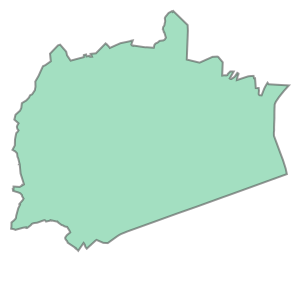

In [40]:
emd.loc[emd['ADM_CD'].isin(_stp_slice_df['potential_area_id'].values[0])].unary_union

In [41]:
_stp_slice_df = pd.DataFrame()
for idx, _trvl_time in enumerate(_stp_total_time):
    if idx == 0:
        continue

    # Get the zone that can be reached within the threshold travel time
    _temp_stp_slice = _stp_df.loc[_stp_df[f'zone_{str(_trvl_time).zfill(3)}'] == 'Y'].reset_index(drop=True)
    _temp_stp_slice['ADM_CD'] = _temp_stp_slice['ADM_CD'].astype(str)

    if _temp_stp_slice.shape[0] > 0:
        
        # Calculate Geometry
        _temp_geom = emd.loc[emd['ADM_CD'].isin(_temp_stp_slice['ADM_CD'].values), 'geometry'].unary_union

        _stp_slice_df = pd.concat([_stp_slice_df, pd.DataFrame({'elapsed_time': [_trvl_time],
                                                                'potential_area_id': [_temp_stp_slice['ADM_CD'].values], 
                                                                'potential_area_count': [_temp_stp_slice.shape[0]],
                                                                'geometry': [_temp_geom]
                                                                }, )], axis=0).reset_index(drop=True)      

# _stp_slice_df

_stp_slice_gdf = gpd.GeoDataFrame(_stp_slice_df, geometry='geometry', crs=emd.crs)
_stp_slice_gdf

elapsed_time                                  potential_area_id  \
0             5                     [11060720, 11060890, 11060710]   
1            10  [11040700, 11060720, 11080720, 11010710, 11060...   
2            15  [11040540, 11040550, 11040700, 11080660, 11080...   
3            20  [11040520, 11020590, 11040550, 11040590, 11080...   
4            25  [11010540, 11010550, 11030740, 11020580, 11020...   
5            30  [11010530, 11010550, 11020680, 11030510, 11030...   
6            35  [11010530, 11020680, 11030530, 11030570, 11030...   
7            40  [11030570, 11030590, 11140610, 11130740, 11140...   

   potential_area_count                                           geometry  
0                     3  POLYGON ((961990.360 1955166.461, 961999.878 1...  
1                    20  POLYGON ((957894.113 1953277.217, 957894.137 1...  
2                    32  POLYGON ((958206.930 1951835.612, 958203.566 1...  
3                    29  POLYGON ((956989.638 1950185.511, 956978.708 1...  
4                    17  POLYGON ((955416.163 1948960.427, 955412.632 1...  
5                    23  POLYGON ((953270.006 1949300.401, 953263.103 1...  
6                    28  POLYGON ((952438.976 1947172.569, 952437.385 1...  
7                     9  POLYGON ((949206.333 1949086.288, 949211.126 1...

In [42]:
_stp_slice_gdf[['elapsed_time', 'geometry']].explore('elapsed_time')

In [43]:
# Create Slice of STP by dissolving the zone that can be reached within each time zone
def create_slice_from_stp_df(_stp_df, _emd, _origin_emd_cd, _dest_emd_cd):
    _stp_slice_df = pd.DataFrame()
    for idx, _trvl_time in enumerate(_stp_total_time):
        if idx == 0:
            continue

        # Get the zone that can be reached within the threshold travel time
        _temp_stp_slice = _stp_df.loc[_stp_df[f'zone_{str(_trvl_time).zfill(3)}'] == 'Y'].reset_index(drop=True)
        _temp_stp_slice['ADM_CD'] = _temp_stp_slice['ADM_CD'].astype(str)

        if _temp_stp_slice.shape[0] > 0:
            
            # Calculate Geometry
            _temp_geom = _emd.loc[_emd['ADM_CD'].isin(_temp_stp_slice['ADM_CD'].values), 'geometry'].unary_union

            _stp_slice_df = pd.concat([_stp_slice_df, pd.DataFrame({'elapsed_time': [_trvl_time],
                                                                    'potential_area_id': [_temp_stp_slice['ADM_CD'].values], 
                                                                    'potential_area_count': [_temp_stp_slice.shape[0]],
                                                                    'geometry': [_temp_geom]
                                                                    }, )], axis=0).reset_index(drop=True)      


    # Convert DataFrame to GeoDataFrame
    _stp_slice_gdf = gpd.GeoDataFrame(_stp_slice_df, geometry='geometry', crs=emd.crs)

    # Enter the origin zone ID and destination zone ID
    _stp_slice_gdf['from_emd_cd'] = _origin_emd_cd # _stp_df.loc[_stp_df['travel_time_from_zone'] == 0, 'taz_id'].values[0]
    _stp_slice_gdf['to_adm_cd'] = _dest_emd_cd # _stp_df.loc[_stp_df['travel_time_to_zone'] == 0, 'taz_id'].values[0]

    return _stp_slice_gdf

stp_slice_gdf = create_slice_from_stp_df(stp_df, emd, '11060710', '11140780')
stp_slice_gdf

elapsed_time                                  potential_area_id  \
0             5                     [11060720, 11060890, 11060710]   
1            10  [11060720, 11080720, 11010710, 11060710, 11060...   
2            15  [11040540, 11080820, 11080830, 11060910, 11080...   
3            20  [11040520, 11020590, 11040590, 11080810, 11080...   
4            25  [11010540, 11010550, 11030740, 11020580, 11020...   
5            30  [11010530, 11010550, 11020680, 11030520, 11030...   
6            35  [11010530, 11020680, 11030530, 11030580, 11010...   
7            40  [11140610, 11130740, 11140770, 11140600, 11140...   

   potential_area_count                                           geometry  \
0                     3  POLYGON ((961990.360 1955166.461, 961999.878 1...   
1                    14  POLYGON ((957894.083 1953278.257, 957894.113 1...   
2                    23  POLYGON ((957253.126 1951746.394, 957251.334 1...   
3                    25  POLYGON ((957275.834 1950516.945, 957266.207 1...   
4                    16  POLYGON ((955416.163 1948960.427, 955412.632 1...   
5                    18  POLYGON ((953270.006 1949300.401, 953263.103 1...   
6                    22  POLYGON ((951999.665 1949168.343, 951995.810 1...   
7                     5  POLYGON ((952449.045 1951143.782, 952457.104 1...   

  from_emd_cd to_adm_cd  
0    11060710  11140780  
1    11060710  11140780  
2    11060710  11140780  
3    11060710  11140780  
4    11060710  11140780  
5    11060710  11140780  
6    11060710  11140780  
7    11060710  11140780

# DONE
